<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [3]:
#pip install pandas_profiling

In [4]:
import time
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, 
    roc_auc_score, 
    roc_curve, 
    classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.utils import shuffle

In [5]:
warnings.filterwarnings('ignore')

In [6]:
plt.rcParams ['figure.figsize'] = [13, 6]

## Подготовка данных

In [7]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('Churn.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В первую очередь приведем в соответствие название столбцов:

In [9]:
df.columns = df.columns.str.lower()
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [10]:
df.columns = ['row_number', 'customer_id', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_crcard',
       'isactive_member', 'estimated_salary', 'exited']
df.columns

Index(['row_number', 'customer_id', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_crcard',
       'isactive_member', 'estimated_salary', 'exited'],
      dtype='object')

Веведем детальную информацию о датафрейме:

In [11]:
profile = ProfileReport(df, progress_bar=False)
profile

Заменим занчения *NaN* в столбце `tenure` на случайные значения в диапазоне от 0 до 10:

In [12]:
df['tenure'] = df['tenure'].apply(lambda x: np.random.randint(0.0, 11.0) if pd.isna(x) else x)
df.isna().mean()

row_number          0.0
customer_id         0.0
surname             0.0
creditscore         0.0
geography           0.0
gender              0.0
age                 0.0
tenure              0.0
balance             0.0
num_of_products     0.0
has_crcard          0.0
isactive_member     0.0
estimated_salary    0.0
exited              0.0
dtype: float64

In [13]:
df['tenure'].value_counts()

8.0     1034
1.0     1034
2.0     1030
5.0     1023
7.0     1023
3.0     1014
9.0      980
4.0      976
6.0      966
0.0      474
10.0     446
Name: tenure, dtype: int64

Удалим столбцы `row_number`, `customer_id` и `surname`:
- `row_number` повторяем индекс датафрейма;
- `customer_id` уникальный номер пользователя в банке, который никак не зависит от самого пользователя;
- `surname` фамиля пользователя так же не имеет никакого влияния на закрытие счета в банке.

In [14]:
df = df.drop(['row_number','customer_id','surname'], axis=1)
df.shape

(10000, 11)

Используем метод прямого кодирования с защитой от дамми-ловушки для создания датафрейма:

In [16]:
ohe_df = pd.get_dummies(df, drop_first=True)
ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   creditscore        10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  float64
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_crcard         10000 non-null  int64  
 6   isactive_member    10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


In [17]:
ohe_df.head()

creditscore  age  tenure    balance  num_of_products  has_crcard  \
0          619   42     2.0       0.00                1           1   
1          608   41     1.0   83807.86                1           0   
2          502   42     8.0  159660.80                3           1   
3          699   39     1.0       0.00                2           0   
4          850   43     2.0  125510.82                1           1   

   isactive_member  estimated_salary  exited  geography_Germany  \
0                1         101348.88       1                  0   
1                1         112542.58       0                  0   
2                0         113931.57       1                  0   
3                0          93826.63       0                  0   
4                1          79084.10       0                  0   

   geography_Spain  gender_Male  
0                0            0  
1                1            0  
2                0            0  
3                0            0  
4                1            0

**Вывод:** Подготовили данные для дальнейшего исследования:
- привели название столбцов в соответствии с snake_case;
- удалили данные, которые не могли быть выделены как признак для построения модели классификации;
- создали отдельный датафрейм по методу прямого кодирования с защитой от дамми-ловушки.

## Исследование задачи

Разобьем данные по принципу 60/20/20:

In [18]:
features = ohe_df.drop('exited', axis=1)
target = ohe_df['exited']

features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=15243)
features_val, features_test, target_val, target_test = train_test_split(features_val, target_val, test_size=0.5, 
                                                                              random_state=15243 )
print(features_train.shape, features_val.shape, features_test.shape)
print(target_train.shape, target_val.shape, target_test.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


Проведем масштабирование:

In [19]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'num_of_products','has_crcard', 
          'isactive_member', 'estimated_salary','geography_Germany', 'geography_Spain', 'gender_Male']

In [20]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_val[numeric] = scaler.transform(features_val[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Обратим внимание на наличие дисбаланса классов:

In [21]:
target.value_counts()

0    7963
1    2037
Name: exited, dtype: int64

Дисбаланс составляет 1 к 4. Для начала посмотрим какие результаты покажут модели без исправления баланса. Для построения графиков сделаем фунцию:

In [22]:
def graf(z:dict, typ, xticks=False):
    x = []
    y = []
    title_type = {
        'dtc': 'Дерево решений',
        'rfc': 'Случайный лес',
        'lr': 'Логистическая регрессия'
    }
    xlabel_type = {
        'dtc': 'Максимальная глубина',
        'rfc': 'Количество деревьев в лесу',
        'lr': 'Количество итераций'
    }
    ylabel_type = {
        'dtc': 'F1-мера',
        'rfc': 'Лучший показатель F1-меры',
        'lr': 'F1-мера'
    }
    
    for k, v in z.items():
        x.append(k)
        y.append(v)
    
    ax = plt.subplot(111)
    plt.plot(x, y, 'o-')
    plt.title(title_type[typ], fontsize=16)
    plt.xlabel(xlabel_type[typ], fontsize=14)
    plt.ylabel(ylabel_type[typ], fontsize=14)
    plt.grid(True)
    if xticks == True:
        ax.set_xticks([i for i in range(x[0],x[-1]+1)])

    plt.show()

Дерево решений:

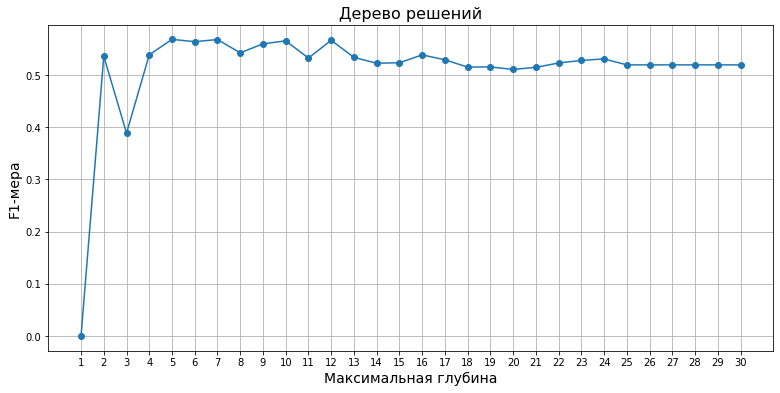

Лучшие показатели: Max depth 5, F1-score 0.568595041322314
----------------------------------------
CPU times: user 1.42 s, sys: 10.8 ms, total: 1.43 s
Wall time: 1.43 s


In [23]:
%%time

best_depth = 0
best_f1_score = 0
z = {}

for depth in range(1, 31):
    model = DecisionTreeClassifier(random_state=15243, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_val = model.predict(features_val)
    f1_scr = f1_score(target_val, predicted_val)
    z[depth] = f1_scr
    if f1_scr > best_f1_score:
        best_f1_score = f1_scr
        best_depth = depth
        
graf(z, 'dtc', True)
        
print('Лучшие показатели: Max depth {}, F1-score {}'.format(best_depth, 
                                                            best_f1_score))
print('-' * 40)

Случайный лес:

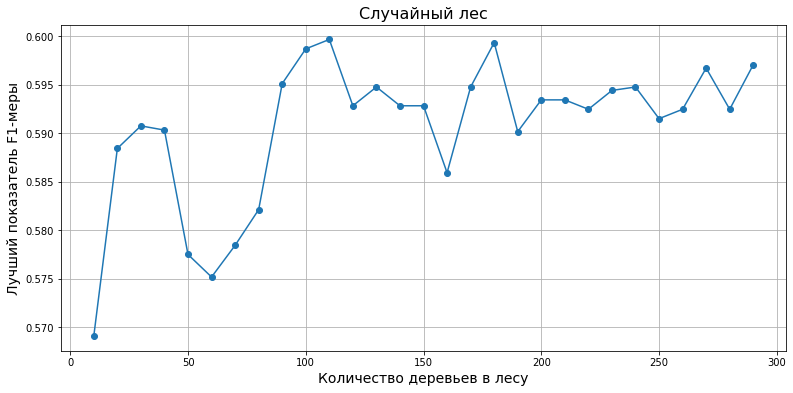

Лучшие показатели: N estimators 110, F1-score 0.5996758508914101
----------------------------------------
CPU times: user 33.3 s, sys: 140 ms, total: 33.4 s
Wall time: 33.4 s


In [24]:
%%time

best_est = 0
best_f1_score = 0
z = {}

for est in range(10, 300, 10):
    model = RandomForestClassifier(random_state=15243, n_estimators=est)
    model.fit(features_train, target_train)
    predicted_val = model.predict(features_val)
    f1_scr = f1_score(target_val, predicted_val)
    z[est] = f1_scr
    if f1_scr > best_f1_score:
        best_f1_score = f1_scr
        best_est = est

graf(z, 'rfc')
print('Лучшие показатели: N estimators {}, F1-score {}'.format(best_est, 
                                                            best_f1_score))
print('-' * 40)

Лучший результат в районе N estimators 40. Возьмем диапазон от 30 до 50. Также будем сотреть как меняются значения при изменении глубины:

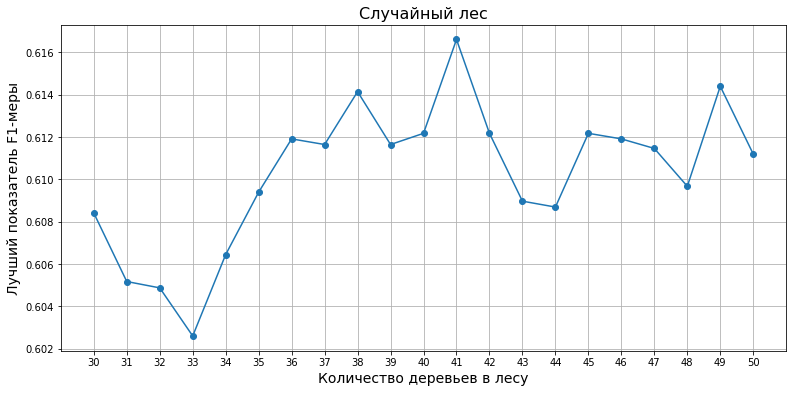

Лучшие показатели: N estimators 41, Max depth 16 F1-score 0.6166134185303515
----------------------------------------
CPU times: user 1min 41s, sys: 298 ms, total: 1min 41s
Wall time: 1min 42s


In [25]:
%%time

best_depth = 0
best_est = 0
best_f1_score = 0
z = {}

for est in range(30, 51, 1):
    b_est_f1 = 0
    for depth in range(1, 21):
        model = RandomForestClassifier(random_state=15243, 
                                       n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predicted_val = model.predict(features_val)
        f1_scr = f1_score(target_val, predicted_val)      
        if f1_scr > best_f1_score:
            best_f1_score = f1_scr
            best_est = est
            best_depth = depth
        if f1_scr > b_est_f1:
            b_est_f1 = f1_scr
    z[est] = b_est_f1
            

graf(z, 'rfc', True)
print('Лучшие показатели: N estimators {}, Max depth {} F1-score {}'.format(
    best_est, best_depth, best_f1_score
))
print('-' * 40)

Логистическая регрессия:

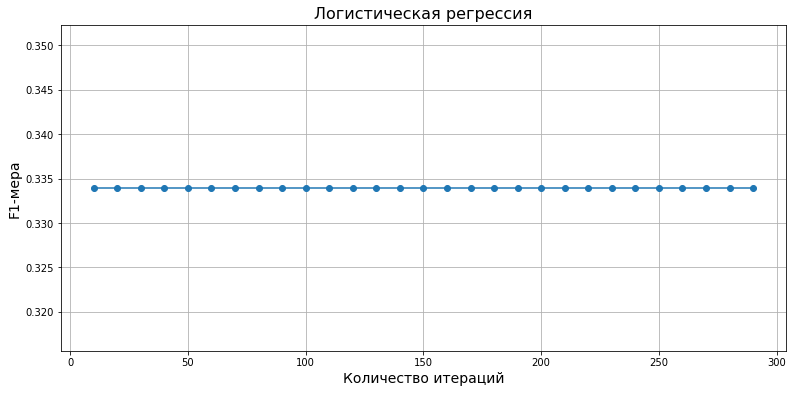

Лучшие показатели: Max iter 10, F1-score 0.3339805825242719
----------------------------------------
CPU times: user 3.35 s, sys: 4.4 s, total: 7.76 s
Wall time: 7.77 s


In [26]:
%%time

best_max_iter = 0
best_f1_score = 0
z = {}

for max_iter in range(10, 300, 10):
    model = LogisticRegression(random_state=15243, max_iter=max_iter)
    model.fit(features_train, target_train)
    predicted_val = model.predict(features_val)
    f1_scr = f1_score(target_val, predicted_val)
    z[max_iter] = f1_scr
    if f1_scr > best_f1_score:
        best_f1_score = f1_scr
        best_max_iter = max_iter

graf(z, 'lr')
print('Лучшие показатели: Max iter {}, F1-score {}'.format(best_max_iter, 
                                                            best_f1_score))
print('-' * 40)

Вне зависимости от количества итераций, F1-мера не изменяется. Оставим в моделе стандартное значение.

Проведем оценку accuracy, precision и recall, также покажем F-метрику:

In [27]:
%%time

dtc_model = DecisionTreeClassifier(random_state=15243, max_depth=5)
dtc_model.fit(features_train, target_train)
report = classification_report(target_val, 
                               dtc_model.predict(features_val), 
                               target_names=['0', '1'])
print('Дерево решений')
print()
print(report)
print('-' * 40)

rfc_model = RandomForestClassifier(random_state=15243, n_estimators=39, max_depth=17)
rfc_model.fit(features_train, target_train)
report = classification_report(target_val, 
                               rfc_model.predict(features_val), 
                               target_names=['0', '1'])
print('Случайный лес')
print()
print(report)
print('-' * 40)

lr_model = LogisticRegression(random_state=15243)
lr_model.fit(features_train, target_train)
report = classification_report(target_val, 
                               lr_model.predict(features_val), 
                               target_names=['0', '1'])
print('Логистическая регрессия')
print()
print(report)
print('-' * 40)

Дерево решений

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1617
           1       0.77      0.45      0.57       383

    accuracy                           0.87      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.87      0.86      2000

----------------------------------------
Случайный лес

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1617
           1       0.79      0.49      0.60       383

    accuracy                           0.88      2000
   macro avg       0.84      0.73      0.76      2000
weighted avg       0.87      0.88      0.86      2000

----------------------------------------
Логистическая регрессия

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1617
           1       0.65      0.22      0.33       383

    accuracy                           0.83 

Проведем построение ROC-кривой для кажддой модели. И выведем показатель AUC-ROC:

In [28]:
def auc_plot(model, name):
    probabilities_val = model.predict_proba(features_val)
    probabilities_one_val = probabilities_val[:, 1]
    fpr, tpr, thresholds = roc_curve(target_val, probabilities_one_val)
    auc_roc = roc_auc_score(target_val, probabilities_one_val)
    print('AUC-ROC {}: {}'.format(name, auc_roc))
    
    return fpr, tpr

AUC-ROC Дерево решений: 0.8547749030777751
AUC-ROC Случайный лес: 0.8694961013125877
AUC-ROC Логистическая регрессия: 0.7949156401226525


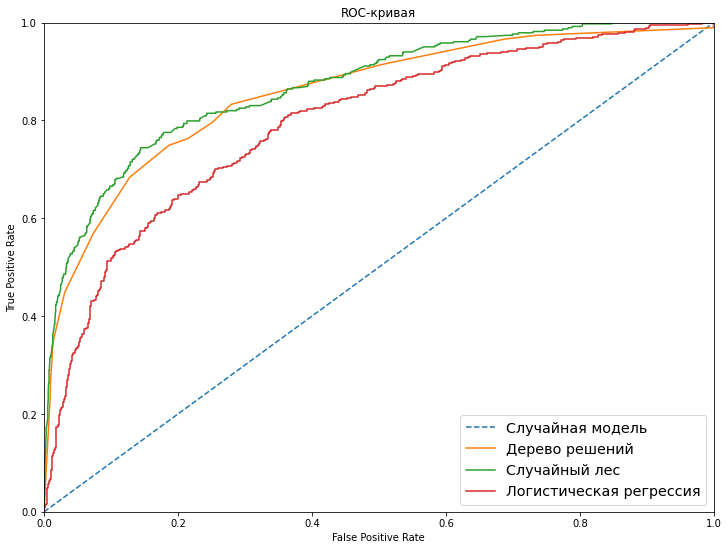

In [29]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')

fpr, tpr = auc_plot(dtc_model, 'Дерево решений')
plt.plot(fpr, tpr, label='Дерево решений')

fpr, tpr = auc_plot(rfc_model, 'Случайный лес')
plt.plot(fpr, tpr, label='Случайный лес')

fpr, tpr = auc_plot(lr_model, 'Логистическая регрессия')
plt.plot(fpr, tpr, label='Логистическая регрессия')


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

Метрика F1 и AUC-ROC лучшая в моделе Случайного леса.

**Вывод:** В данных сущестует дисбаланс классов в соотношении 1к4. Возможно дисбаланс влияет на качетво моделей. Все модели имеют recall ниже, чем percision, из-за перекоса данных, что влияет на F-меру.

## Борьба с дисбалансом

Для исправления дисбаланса сравним несколько методов:
- взвешевание классов;
- уменьшенное количество классов 0;
- увеличенное количество классов 1.

Взвешевание классов:

In [30]:
%%time

dtc_model_bal = DecisionTreeClassifier(random_state=15243, max_depth=5, class_weight='balanced')
dtc_model_bal.fit(features_train, target_train)
report = classification_report(target_val, 
                               dtc_model_bal.predict(features_val), 
                               target_names=['0', '1'])
print('Дерево решений')
print()
print(report)
print('-' * 40)

rfc_model_bal = RandomForestClassifier(random_state=15243, n_estimators=39, max_depth=17, class_weight='balanced')
rfc_model_bal.fit(features_train, target_train)
report = classification_report(target_val, 
                               rfc_model_bal.predict(features_val), 
                               target_names=['0', '1'])
print('Случайный лес')
print()
print(report)
print('-' * 40)

lr_model_bal = LogisticRegression(random_state=15243, class_weight='balanced')
lr_model_bal.fit(features_train, target_train)
report = classification_report(target_val, 
                               lr_model_bal.predict(features_val), 
                               target_names=['0', '1'])
print('Логистическая регрессия')
print()
print(report)
print('-' * 40)

Дерево решений

              precision    recall  f1-score   support

           0       0.95      0.75      0.83      1617
           1       0.43      0.82      0.57       383

    accuracy                           0.76      2000
   macro avg       0.69      0.78      0.70      2000
weighted avg       0.85      0.76      0.78      2000

----------------------------------------
Случайный лес

              precision    recall  f1-score   support

           0       0.89      0.97      0.92      1617
           1       0.77      0.47      0.58       383

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.75      2000
weighted avg       0.86      0.87      0.86      2000

----------------------------------------
Логистическая регрессия

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1617
           1       0.39      0.72      0.50       383

    accuracy                           0.73 

Лучший результат F1-меры показала модель Случайного леса (0.60). F1-мера модели Дерево решений осталась без изменений, а модели Логистическая регрессия увеличилась с 0.34 до 0.50.

Уменьшенное количество класса 0:

In [31]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=15243)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=15243)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=15243)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(target_downsampled.value_counts())

1    1243
0    1189
Name: exited, dtype: int64


In [32]:
%%time

dtc_model_down = DecisionTreeClassifier(random_state=15243, max_depth=5)
dtc_model_down.fit(features_downsampled, target_downsampled)
report = classification_report(target_val, 
                               dtc_model_down.predict(features_val), 
                               target_names=['0', '1'])
print('Дерево решений')
print()
print(report)
print('-' * 40)

rfc_model_down = RandomForestClassifier(random_state=15243, n_estimators=39, max_depth=17)
rfc_model_down.fit(features_downsampled, target_downsampled)
report = classification_report(target_val, 
                               rfc_model_down.predict(features_val), 
                               target_names=['0', '1'])
print('Случайный лес')
print()
print(report)
print('-' * 40)

lr_model_down = LogisticRegression(random_state=15243)
lr_model_down.fit(features_downsampled, target_downsampled)
report = classification_report(target_val, 
                               lr_model_down.predict(features_val), 
                               target_names=['0', '1'])
print('Логистическая регрессия')
print()
print(report)
print('-' * 40)

Дерево решений

              precision    recall  f1-score   support

           0       0.95      0.72      0.82      1617
           1       0.42      0.85      0.56       383

    accuracy                           0.74      2000
   macro avg       0.68      0.78      0.69      2000
weighted avg       0.85      0.74      0.77      2000

----------------------------------------
Случайный лес

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      1617
           1       0.47      0.78      0.59       383

    accuracy                           0.79      2000
   macro avg       0.71      0.79      0.72      2000
weighted avg       0.85      0.79      0.81      2000

----------------------------------------
Логистическая регрессия

              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1617
           1       0.38      0.74      0.50       383

    accuracy                           0.72 

Луший результат показала модель Случайного леса (0.57). Модель Дерева решений уменьшилась до 0.56. Модель Логистической регрессии осталась без изменений (0.50).

Увеличенное количество класса 1:

In [33]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(target_upsampled.value_counts())

1    4972
0    4757
Name: exited, dtype: int64


In [34]:
%%time

dtc_model_up = DecisionTreeClassifier(random_state=15243, max_depth=5)
dtc_model_up.fit(features_upsampled, target_upsampled)
report = classification_report(target_val, 
                               dtc_model_up.predict(features_val), 
                               target_names=['0', '1'])
print('Дерево решений')
print()
print(report)
print('-' * 40)

rfc_model_up = RandomForestClassifier(random_state=15243, n_estimators=39, max_depth=17)
rfc_model_up.fit(features_upsampled, target_upsampled)
report = classification_report(target_val, 
                               rfc_model_up.predict(features_val), 
                               target_names=['0', '1'])
print('Случайный лес')
print()
print(report)
print('-' * 40)

lr_model_up = LogisticRegression(random_state=15243)
lr_model_up.fit(features_upsampled, target_upsampled)
report = classification_report(target_val, 
                               lr_model_up.predict(features_val), 
                               target_names=['0', '1'])
print('Логистическая регрессия')
print()
print(report)
print('-' * 40)

Дерево решений

              precision    recall  f1-score   support

           0       0.95      0.77      0.85      1617
           1       0.46      0.83      0.59       383

    accuracy                           0.78      2000
   macro avg       0.70      0.80      0.72      2000
weighted avg       0.85      0.78      0.80      2000

----------------------------------------
Случайный лес

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1617
           1       0.69      0.61      0.65       383

    accuracy                           0.87      2000
   macro avg       0.80      0.77      0.79      2000
weighted avg       0.87      0.87      0.87      2000

----------------------------------------
Логистическая регрессия

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1617
           1       0.38      0.74      0.50       383

    accuracy                           0.72 

Лучший результат F1-меры показала модель Случайного леса (0.64). Модель Дерева решений улучшилась, а модель Логистической регрессии осталась без изменений.

Выведем ROC-кривую и AUC-ROC для всех методов балансировки:

AUC-ROC Дерево решений - взвешенные классы: 0.862892795380673
AUC-ROC Случайный лес - взвешенные классы: 0.8601034052358185
AUC-ROC Логистическая регрессия - взвешенные классы: 0.7973925862773308
----------------------------------------
AUC-ROC Дерево решений - уменьшенное количество класса 0: 0.8646673480690639
AUC-ROC Случайный лес - уменьшенное количество класса 0: 0.8624616711151586
AUC-ROC Логистическая регрессия - уменьшенное количество класса 0: 0.7970260499167624
----------------------------------------
AUC-ROC Дерево решений - увеличенное количество класса 1: 0.862243686935966
AUC-ROC Случайный лес - увеличенное количество класса 1: 0.8672137262215591
AUC-ROC Логистическая регрессия - увеличенное количество класса 1: 0.7974507153917821


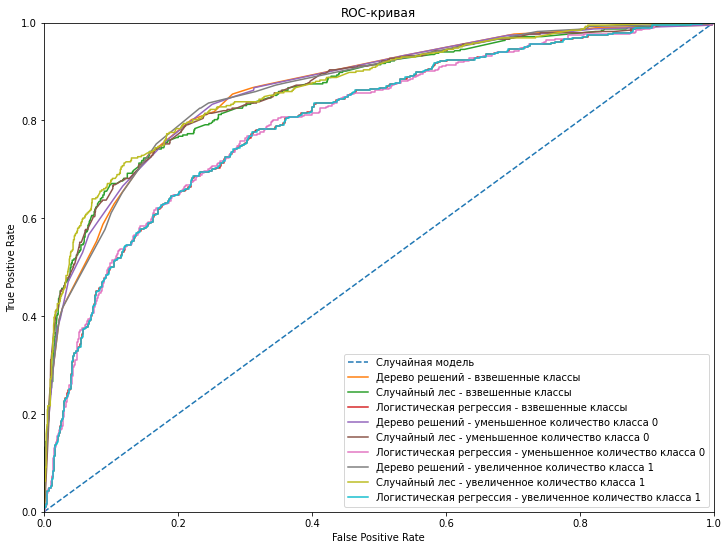

In [35]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')

fpr, tpr = auc_plot(dtc_model_bal, 'Дерево решений - взвешенные классы')
plt.plot(fpr, tpr, label='Дерево решений - взвешенные классы')

fpr, tpr = auc_plot(rfc_model_bal, 'Случайный лес - взвешенные классы')
plt.plot(fpr, tpr, label='Случайный лес - взвешенные классы')

fpr, tpr = auc_plot(lr_model_bal, 'Логистическая регрессия - взвешенные классы')
plt.plot(fpr, tpr, label='Логистическая регрессия - взвешенные классы')

print('-' * 40)

fpr, tpr = auc_plot(dtc_model_down, 'Дерево решений - уменьшенное количество класса 0')
plt.plot(fpr, tpr, label='Дерево решений - уменьшенное количество класса 0')

fpr, tpr = auc_plot(rfc_model_down, 'Случайный лес - уменьшенное количество класса 0')
plt.plot(fpr, tpr, label='Случайный лес - уменьшенное количество класса 0')

fpr, tpr = auc_plot(lr_model_down, 'Логистическая регрессия - уменьшенное количество класса 0')
plt.plot(fpr, tpr, label='Логистическая регрессия - уменьшенное количество класса 0')

print('-' * 40)

fpr, tpr = auc_plot(dtc_model_up, 'Дерево решений - увеличенное количество класса 1')
plt.plot(fpr, tpr, label='Дерево решений - увеличенное количество класса 1')

fpr, tpr = auc_plot(rfc_model_up, 'Случайный лес - увеличенное количество класса 1')
plt.plot(fpr, tpr, label='Случайный лес - увеличенное количество класса 1')

fpr, tpr = auc_plot(lr_model_up, 'Логистическая регрессия - увеличенное количество класса 1')
plt.plot(fpr, tpr, label='Логистическая регрессия - увеличенное количество класса 1')


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right')

plt.title("ROC-кривая")
plt.show()

**Вывод:** Балансировка классов улучшила показатель метрики F1-меры. Лучшим решением стало увеличение количества классов 1 в тренировочной выборке.

Стоит отметить, что при балансировке классов метрика recall значительно увеличилась, в то время как percison уменьшилась.

## Тестирование модели

К тестовой выборке применем модель Случайного леса. Исследуем гиперпараметры и улучшим F-меру модели:

Увеличим диапазон до 500 для гиперпараметра n_estimators:

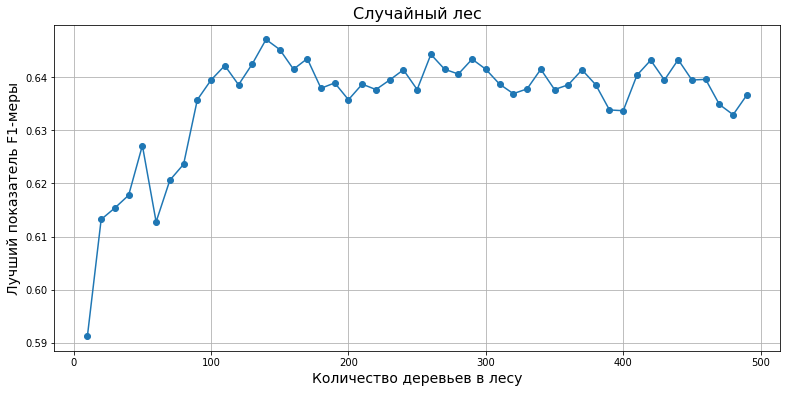

Лучшие показатели: N estimators 140, F1-score 0.6470588235294117
----------------------------------------
CPU times: user 2min 9s, sys: 417 ms, total: 2min 9s
Wall time: 2min 10s


In [36]:
%%time

best_est = 0
best_f1_score = 0
z = {}

for est in range(10, 500, 10):
    model = RandomForestClassifier(random_state=15243, n_estimators=est)
    model.fit(features_upsampled, target_upsampled)
    predicted_val = model.predict(features_val)
    f1_scr = f1_score(target_val, predicted_val)
    z[est] = f1_scr
    if f1_scr > best_f1_score:
        best_f1_score = f1_scr
        best_est = est

graf(z, 'rfc')
print('Лучшие показатели: N estimators {}, F1-score {}'.format(best_est, 
                                                            best_f1_score))
print('-' * 40)

Изучим более детально диапазон от 120 до 140 включительно. Также будем проверять с гиперпараметром max_depth: 

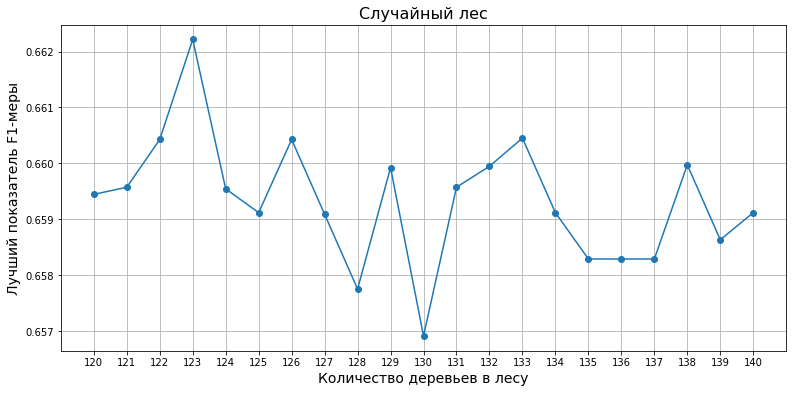

Лучшие показатели: N estimators 123, Max depth 15 F1-score 0.6622162883845127
----------------------------------------
CPU times: user 7min 30s, sys: 1.33 s, total: 7min 32s
Wall time: 7min 32s


In [37]:
%%time

best_depth = 0
best_est = 0
best_f1_score = 0
z = {}

for est in range(120, 141, 1):
    b_est_f1 = 0
    for depth in range(1, 21):
        model = RandomForestClassifier(random_state=15243, 
                                       n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predicted_val = model.predict(features_val)
        f1_scr = f1_score(target_val, predicted_val)      
        if f1_scr > best_f1_score:
            best_f1_score = f1_scr
            best_est = est
            best_depth = depth
        if f1_scr > b_est_f1:
            b_est_f1 = f1_scr
    z[est] = b_est_f1
            

graf(z, 'rfc', True)
print('Лучшие показатели: N estimators {}, Max depth {} F1-score {}'.format(
    best_est, best_depth, best_f1_score
))
print('-' * 40)

Стандартный гиперпараметр criterion является *gini*. Попробуем использовать *entropy* и посмотрим на результат:

In [38]:
%%time

model = RandomForestClassifier(random_state=15243, n_estimators=123, max_depth=11, criterion='entropy')
model.fit(features_upsampled, target_upsampled)
predicted_val = model.predict(features_val)
print('F1-мера при гиперпараметре criterion="entropy" {}'.format(f1_score(target_val, predicted_val)))
print('-' * 40)

F1-мера при гиперпараметре criterion="entropy" 0.6610778443113773
----------------------------------------
CPU times: user 1.31 s, sys: 3.99 ms, total: 1.32 s
Wall time: 1.32 s


F1-мера уменьшилась. Оставим стандартный гиперпараметр criterion='gini'. Далее изменим геперпараметр min_samples_split:

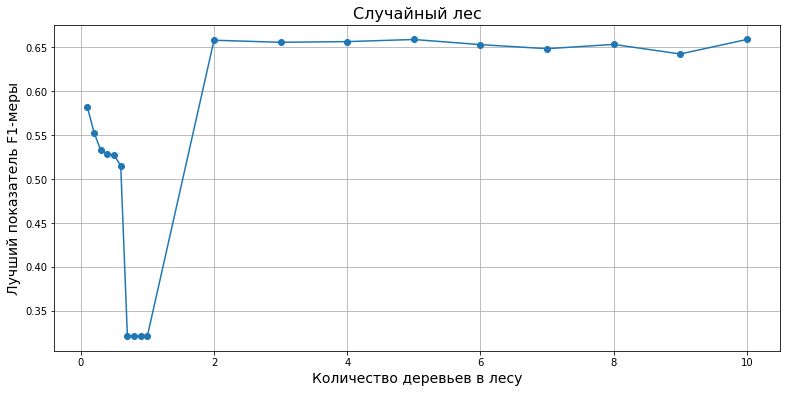

Лучшие показатели: min_samples_split 10, F1-score 0.6586826347305389
----------------------------------------
CPU times: user 15 s, sys: 51.9 ms, total: 15.1 s
Wall time: 15.1 s


In [39]:
%%time

best_mss = 0
best_f1_score = 0
z = {}

for mss in range(1, 11):
    model = RandomForestClassifier(random_state=15243, n_estimators=123, 
                                   max_depth=11, min_samples_split=mss/10)
    model.fit(features_upsampled, target_upsampled)
    predicted_val = model.predict(features_val)
    f1_scr = f1_score(target_val, predicted_val)
    z[mss/10] = f1_scr
    if f1_scr > best_f1_score:
        best_f1_score = f1_scr
        best_mss = mss/10
        
for mss in range(2, 11):
    model = RandomForestClassifier(random_state=15243, n_estimators=123, 
                                   max_depth=11, min_samples_split=mss)
    model.fit(features_upsampled, target_upsampled)
    predicted_val = model.predict(features_val)
    f1_scr = f1_score(target_val, predicted_val)
    z[mss] = f1_scr
    if f1_scr > best_f1_score:
        best_f1_score = f1_scr
        best_mss = mss

graf(z, 'rfc')
print('Лучшие показатели: min_samples_split {}, F1-score {}'.format(best_mss, 
                                                            best_f1_score))
print('-' * 40)

Изменим гиперпараметр min_samples_leaf:

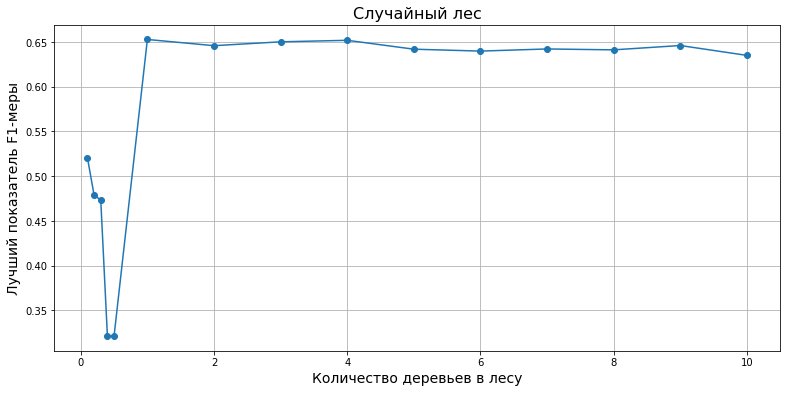

Лучшие показатели: min_samples_leaf 1, F1-score 0.6528117359413204
----------------------------------------
CPU times: user 13.5 s, sys: 55.8 ms, total: 13.6 s
Wall time: 13.6 s


In [40]:
%%time

best_msl = 0
best_f1_score = 0
z = {}

for msl in range(1, 6):
    model = RandomForestClassifier(random_state=15243, n_estimators=123, max_depth=11, 
                                   min_samples_split=6, min_samples_leaf=msl/10)
    model.fit(features_upsampled, target_upsampled)
    predicted_val = model.predict(features_val)
    f1_scr = f1_score(target_val, predicted_val)
    z[msl/10] = f1_scr
    if f1_scr > best_f1_score:
        best_f1_score = f1_scr
        best_msl = msl/10
        
for msl in range(1, 11):
    model = RandomForestClassifier(random_state=15243, n_estimators=123, max_depth=11, 
                                   min_samples_split=6, min_samples_leaf=msl)
    model.fit(features_upsampled, target_upsampled)
    predicted_val = model.predict(features_val)
    f1_scr = f1_score(target_val, predicted_val)
    z[msl] = f1_scr
    if f1_scr > best_f1_score:
        best_f1_score = f1_scr
        best_msl = msl

graf(z, 'rfc')
print('Лучшие показатели: min_samples_leaf {}, F1-score {}'.format(best_msl, 
                                                            best_f1_score))
print('-' * 40)

Сохраним гиперпараметры в одну переменную лучшие гиперпараметры:

In [41]:
params = {'n_estimators':123,
          'max_depth':11,
          'random_state':15243,
          'min_samples_leaf':1,
          'min_samples_split':6
          }

Проверим на тестовой выборке модель Случайного леса - увеличенное количество класса 1:

In [42]:
%%time

rfc_model_up = RandomForestClassifier(**params)
rfc_model_up.fit(features_upsampled, target_upsampled)
report = classification_report(target_test, 
                               rfc_model_up.predict(features_test), 
                               target_names=['0', '1'])
print('Случайный лес - увеличенное количество классов 1')
print()
print(report)
print('-' * 40)

Случайный лес - увеличенное количество классов 1

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1589
           1       0.57      0.67      0.62       411

    accuracy                           0.83      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.84      0.83      0.83      2000

----------------------------------------
CPU times: user 1.14 s, sys: 4 ms, total: 1.14 s
Wall time: 1.14 s


AUC-ROC Случайный лес - увеличенное количество класса 1: 0.8802249596729269


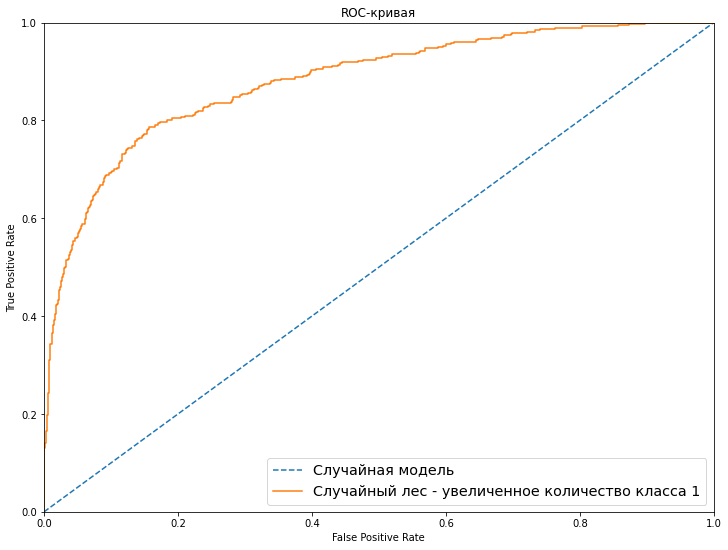

In [43]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')

fpr, tpr = auc_plot(rfc_model_up, 'Случайный лес - увеличенное количество класса 1')
plt.plot(fpr, tpr, label='Случайный лес - увеличенное количество класса 1')


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

**Вывод:** На основе данных с увеличенным количеством класса "1" пересмотрели наилучшие гиперпараметры для модели Случайного леса.

На тестовых данных удалось добиться F1-меры в 0.63, что соответствует условиям задачи. По сравнению с тренировочной выборкой F1-мера уменьшилась на 0.01, но AUC-ROC модели увеличился с 0.871 до 0.883.

## Общий вывод

В ходе проделанной работы:
- подготовили данные для дальнейшего исследования:
    - привели название столбцов в соответствии с snake_case;
    - удалили данные, которые не могли быть выделены как признак для построения модели классификации;
    - создали отдельный датафрейм по методу прямого кодирования с защитой от дамми-ловушки.
- разбили данные на три выборки (в соотношении 3:1:1): обучающая, валидационная и тестовая. В данных обнаружился дисбаланс в соотношении 1:4;
- создали модели без исправления дисбаланса. Модель Случайного леса даже при наличии дисбаланса уже соответствовала минимальным критериям в F1-мера=0.59 и равнялась 0.62;
- балансировка классов улучшила показатель метрики F1-меры у каждой из моделей (Дерево решений, Случайный лес, Логистическая регрессия). Лучший результат в тренировочной выборке у модели Случайного леса с увеличенным количеством класса "1" (F1-мера=0.64);
- определили наилучшие гиперпараметры модели Случайного леса для увеличения метрики F1-мера. На тестовых данных модель Случайного леса с увеличенным количеством класса "1" показала F1-меру 0.63;
- рассчитали AUC-ROC. На тренировочных данных у модели Случайного леса с увеличенным количеством класса "1" AUC-ROC составляла 0.871, на тестовых данных этот показатель увеличился до 0.883.

In [135]:
start_time = time.time()
importances = rfc_model_up.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model_up.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f'Затраченное время на вычисление важности: {elapsed_time:.3f} секунд')

Затраченное время на вычисление важности: 0.016 секунд


In [136]:
feat_col_transl = ['кредитный рейтинг', 'возраст', 'сколько лет явл-ся клиентом','баланс на счёте', 
                   'кол-во продуктов банка у клиента', 'наличие кредитной карты', 'активность клиента',
                   'активность клиента', 'проживает в Германии', 'проживает в Испании', 'мужчина']
forest_importances = pd.Series(importances, index=feat_col_transl).sort_values(ascending=False)

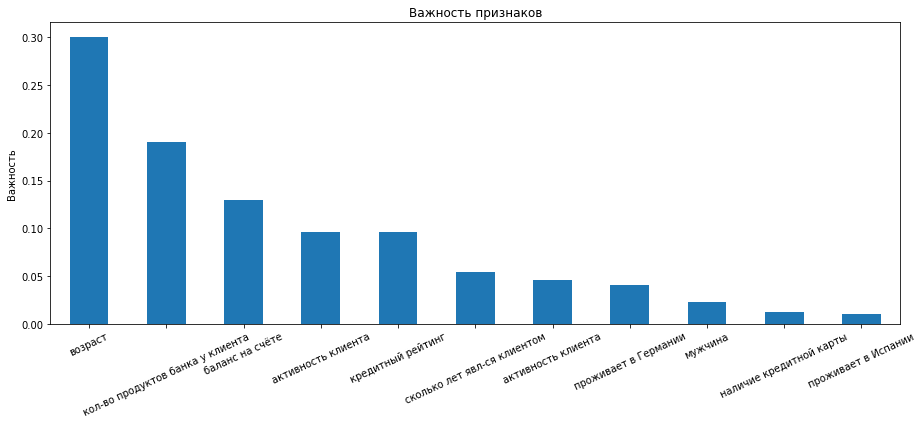

In [137]:
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax, rot=25)
ax.set_title('Важность признаков')
ax.set_ylabel('Важность')
fig.tight_layout()

На основе графика можно сказать, что возраст клиента является самым важным признаком его ухода из банка. Для более детального исследования можно рассмотреть какие группы клиентов чаще уходят из банка и попробовать более детально изучить причины.